In [1]:
!pip install yfinance

!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 10.9 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from pandas.tseries.offsets import BDay
from tqdm import tqdm
from datetime import datetime, timedelta
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Define ticker symbols and date ranges
ticker = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL',
    'META', 'TSLA', 'BRK-B', 'JPM', 'V',
    'SAP.DE', 'SIE.DE', 'ALV.DE', 'VOW3.DE', 'LIN.DE',
    'MC.PA', 'OR.PA', 'AIR.PA', 'ASML.AS', 'NESN.SW']
start_date = '2010-01-01'
end_date = '2025-04-30'
train_end = '2024-12-31'
test_start = '2025-01-01'

# Download adjusted close data
data = yf.download(ticker, start=start_date, end=end_date)

# Keep only the 'Close' price for each ticker
close_data = data['Close'].copy()

# Compute log returns (or log prices)
log_close_data = np.log(close_data)

log_data = pd.concat([close_data, log_close_data], axis=1, keys=['Close', 'LogClose'])

# Optional: View the structure
print(log_data.head())


[*********************100%***********************]  20 of 20 completed

               Close                                                      \
Ticker          AAPL     AIR.PA     ALV.DE    AMZN    ASML.AS      BRK-B   
Date                                                                       
2010-01-04  6.431897  11.483344  41.426899  6.6950  27.861845  66.220001   
2010-01-05  6.443016  11.446408  41.553219  6.7345  27.913523  66.540001   
2010-01-06  6.340533  11.549010  41.876060  6.6125  28.212128  66.199997   
2010-01-07  6.328811  11.663925  41.394131  6.5000  27.695320  66.459999   
2010-01-08  6.370886  11.778842  41.169548  6.6760  26.765055  66.440002   

                                                        ... LogClose  \
Ticker          GOOGL        JPM     LIN.DE      MC.PA  ...     META   
Date                                                    ...            
2010-01-04  15.590930  28.690952  37.267082  58.489910  ...      NaN   
2010-01-05  15.522272  29.246689  37.267082  58.214924  ...      NaN   
2010-01-06  15.130975  29.40738

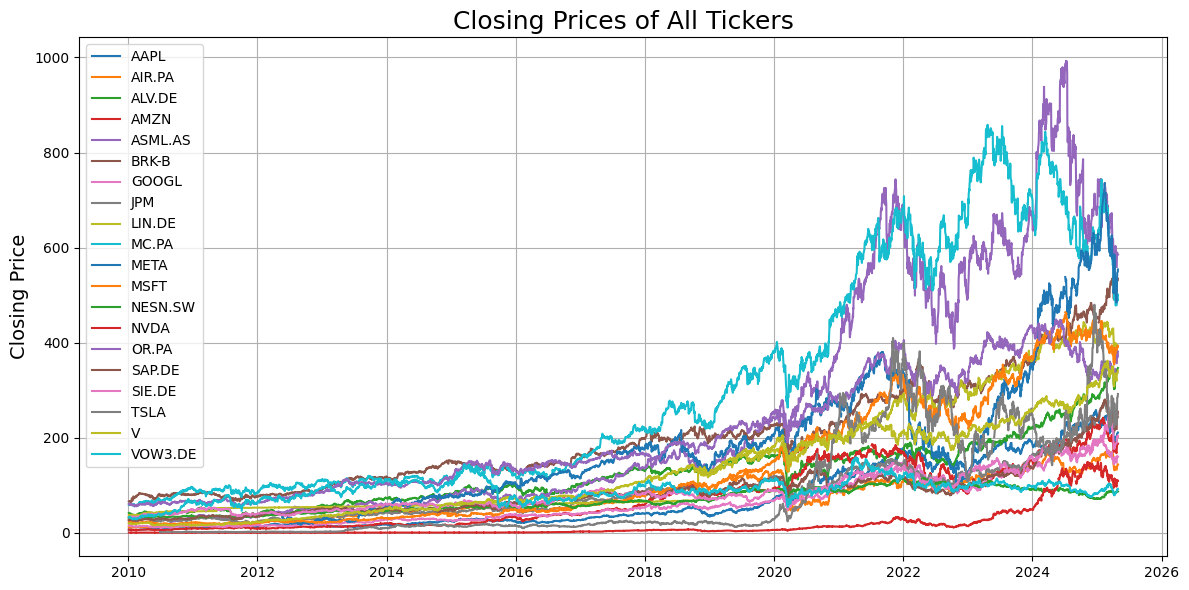

In [5]:
plt.figure(figsize=(12, 6))

for ticker in data['Close'].columns:
    plt.plot(data['Close'][ticker], label=ticker)

plt.ylabel('Closing Price', fontsize=14)
plt.title('Closing Prices of All Tickers', fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


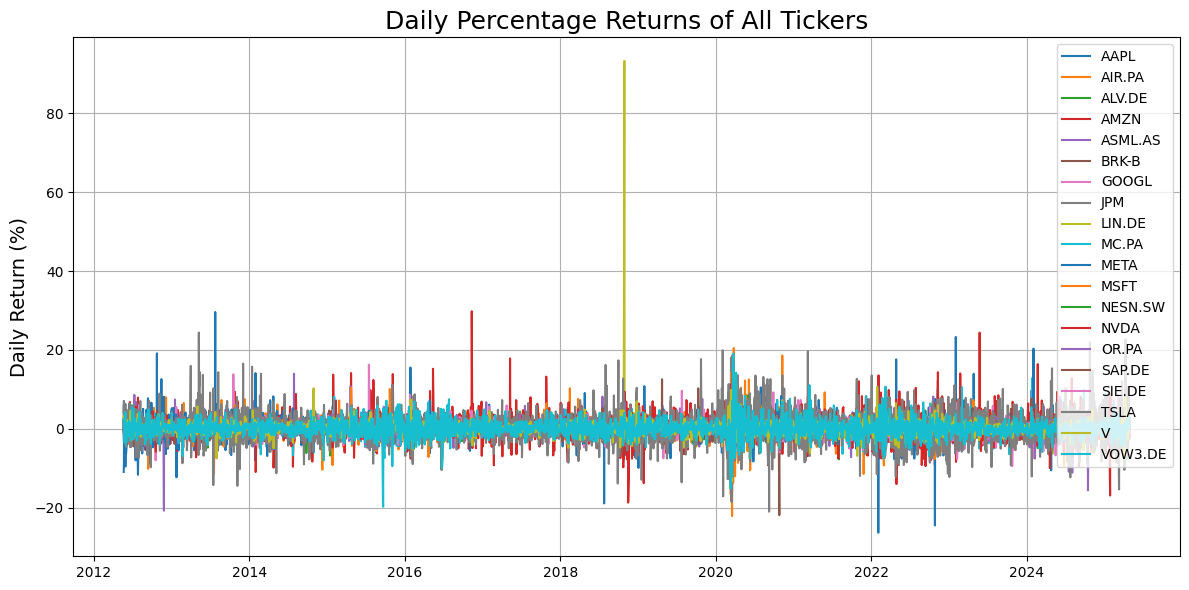

In [6]:
# daily simple returns in %
returns = data['Close'].pct_change().mul(100).dropna()

plt.figure(figsize=(12, 6))
for ticker in returns.columns:
    plt.plot(returns[ticker], label=ticker)

plt.ylabel('Daily Return (%)', fontsize=14)
plt.title('Daily Percentage Returns of All Tickers', fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
log_price = log_close_data.copy()
log_train = log_price.loc[:train_end].copy()
log_test = log_price.loc[test_start:].copy()

In [8]:
# Clean missing data
log_train = log_train.dropna()
log_test = log_test.dropna()


In [9]:
# 3. Rolling forecast setup
history = log_train.copy()
predictions = []
pred_index = []

In [10]:
from arch import arch_model
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Compute daily log returns (% scale for GARCH)
log_returns = log_data.diff().dropna() * 100

# 2. Split training set
train_end = '2023-12-31'
returns_train = log_returns.loc[:train_end]
returns_test = log_returns.loc[test_start:]

# 3. Define GARCH order grid
p_range = range(1, 6)
q_range = range(1, 6)

# 4. Storage for best model results
garch_summary = []

# 5. Grid search for each ticker (filter only LogClose)
logclose_cols = [col for col in log_returns.columns if 'LogClose' in str(col)]
clean_tickers = [col[1] if isinstance(col, tuple) else col for col in logclose_cols]

for col, ticker in tqdm(zip(logclose_cols, clean_tickers), total=len(logclose_cols), desc="GARCH Grid Search"):
    r = returns_train[col].dropna()

    best_bic = np.inf
    best_order = None

    for p in p_range:
        for q in q_range:
            try:
                am = arch_model(r, vol='GARCH', p=p, q=q, mean='Constant', rescale=False)
                res = am.fit(disp='off')
                bic = res.bic

                if bic < best_bic:
                    best_bic = bic
                    best_order = (p, q)
            except Exception:
                continue

    garch_summary.append({
        'Ticker': ticker,
        'Best_BIC_Order': best_order,
        'Best_BIC': best_bic
    })

garch_summary_df = pd.DataFrame(garch_summary)

print("\n✅ Best GARCH(p,q) Models by BIC:\n")
print(garch_summary_df)


GARCH Grid Search: 100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


✅ Best GARCH(p,q) Models by BIC:

     Ticker Best_BIC_Order      Best_BIC
0      AAPL         (1, 1)  10312.026971
1    AIR.PA         (1, 1)  11054.495896
2    ALV.DE         (1, 1)   8997.687630
3      AMZN         (1, 1)  11134.966272
4   ASML.AS         (5, 1)  11245.723745
5     BRK-B         (1, 1)   7769.165885
6     GOOGL         (1, 2)  10256.091206
7       JPM         (1, 1)   9556.599313
8    LIN.DE         (1, 1)  10315.671755
9     MC.PA         (1, 1)  10263.706401
10     META         (2, 3)  12361.364303
11     MSFT         (1, 1)  10014.681525
12  NESN.SW         (1, 1)   7225.580629
13     NVDA         (4, 2)  12805.762239
14    OR.PA         (1, 1)   9068.996723
15   SAP.DE         (3, 1)   9712.667724
16   SIE.DE         (1, 1)   9830.707000
17     TSLA         (1, 1)  14027.567611
18        V         (1, 1)   9343.540866
19  VOW3.DE         (1, 2)  11030.576920


In [11]:
# 2. Compute log prices and daily log returns (%)
log_close_data = np.log(close_data)
log_returns = log_close_data.diff().dropna() * 100  # Returns in percent

# 3. Split train and test sets
returns_train = log_returns.loc[:train_end]
returns_test = log_returns.loc[test_start:]

In [12]:
# 5. Rolling Forecast
forecast_results = []

for _, row in tqdm(garch_summary_df.iterrows(), total=garch_summary_df.shape[0], desc="Rolling Forecast"):
    ticker = row['Ticker']
    best_p, best_q = row['Best_BIC_Order']

    train_series = returns_train[ticker].dropna()
    test_series = returns_test[ticker].dropna()

    rolling_forecast = []

    for i in range(len(test_series)):
        combined = pd.concat([train_series, test_series.iloc[:i]])
        try:
            am = arch_model(combined, vol='GARCH', p=best_p, q=best_q, mean='Constant', rescale=False)
            res = am.fit(disp='off')
            forecast = res.forecast(horizon=1)
            variance = forecast.variance.values[-1, 0]
            rolling_forecast.append(variance)
        except:
            rolling_forecast.append(np.nan)

    forecast_results.append(pd.DataFrame({
        'Date': test_series.index,
        'Ticker': ticker,
        'Actual': test_series.values,
        'Forecasted_Variance': rolling_forecast
    }))



Rolling Forecast: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


In [13]:
# 6. Combine forecasts
rolling_df = pd.concat(forecast_results, ignore_index=True)
rolling_df['Forecasted_Std'] = np.sqrt(rolling_df['Forecasted_Variance'])

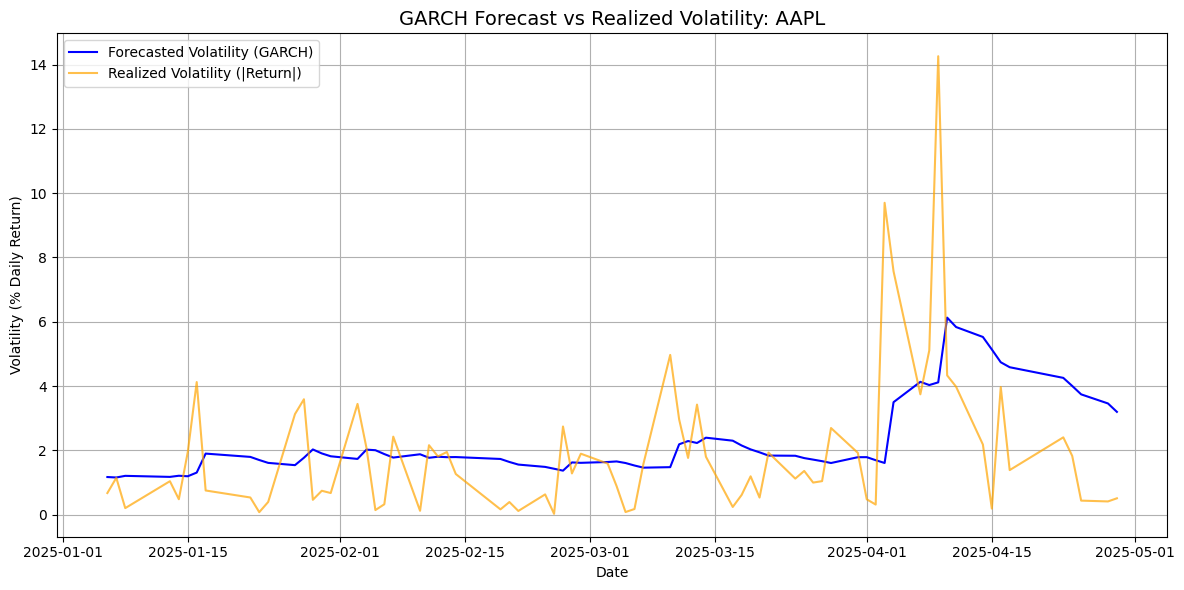

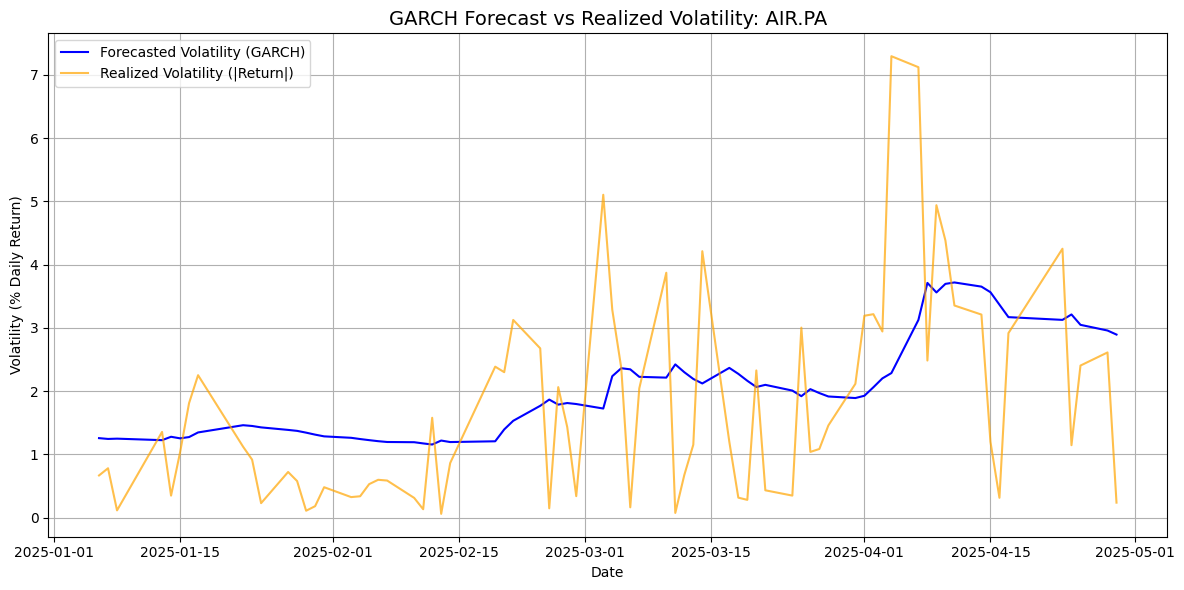

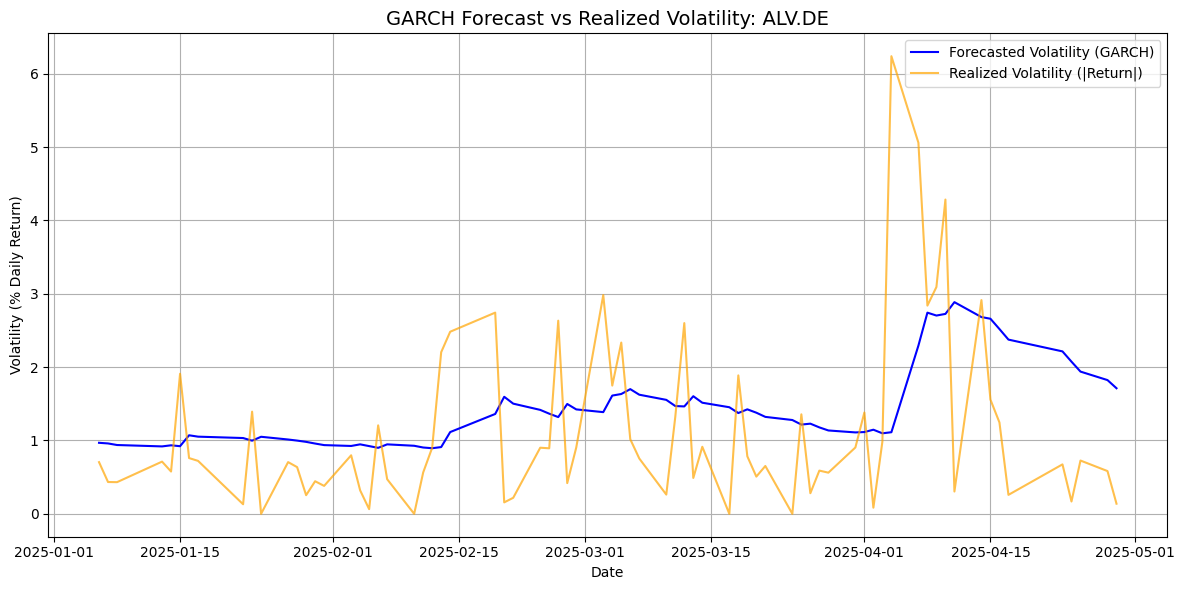

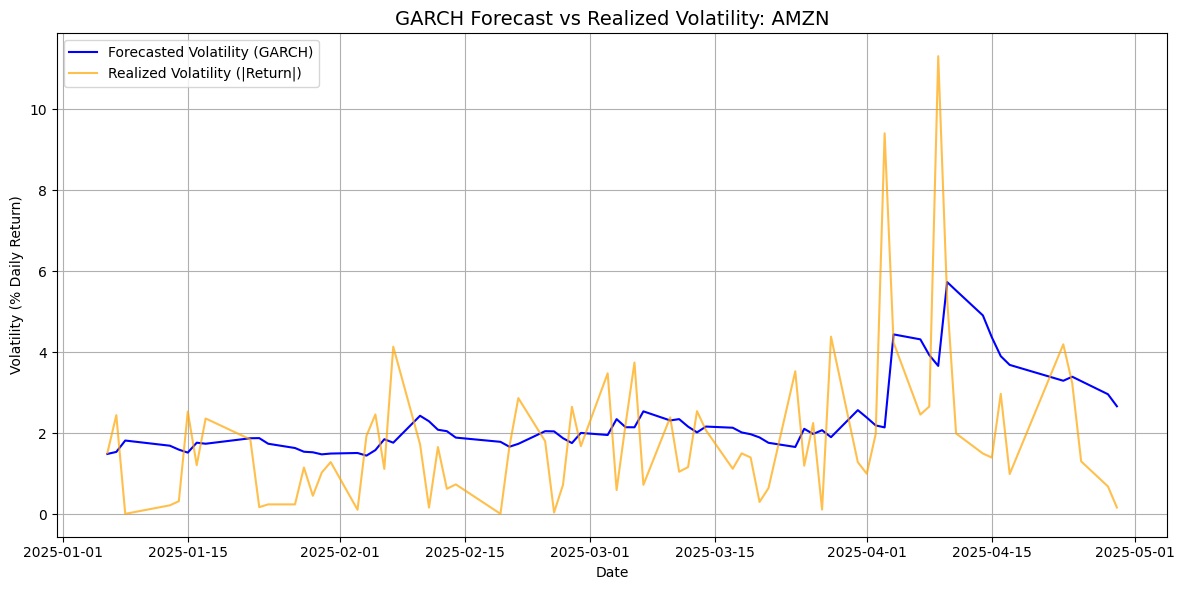

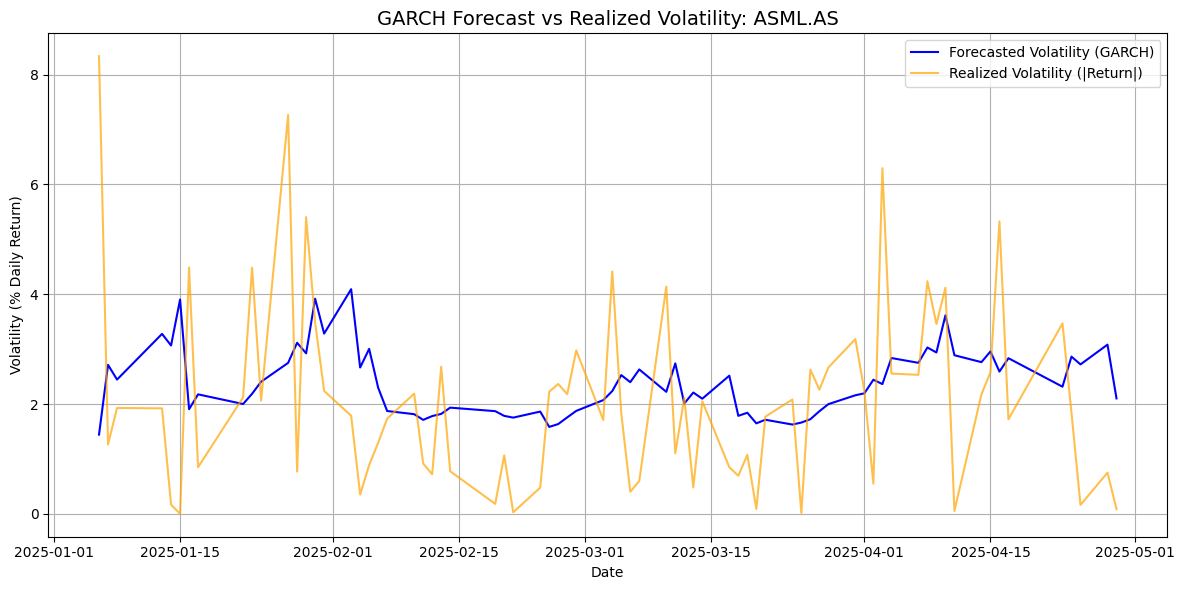

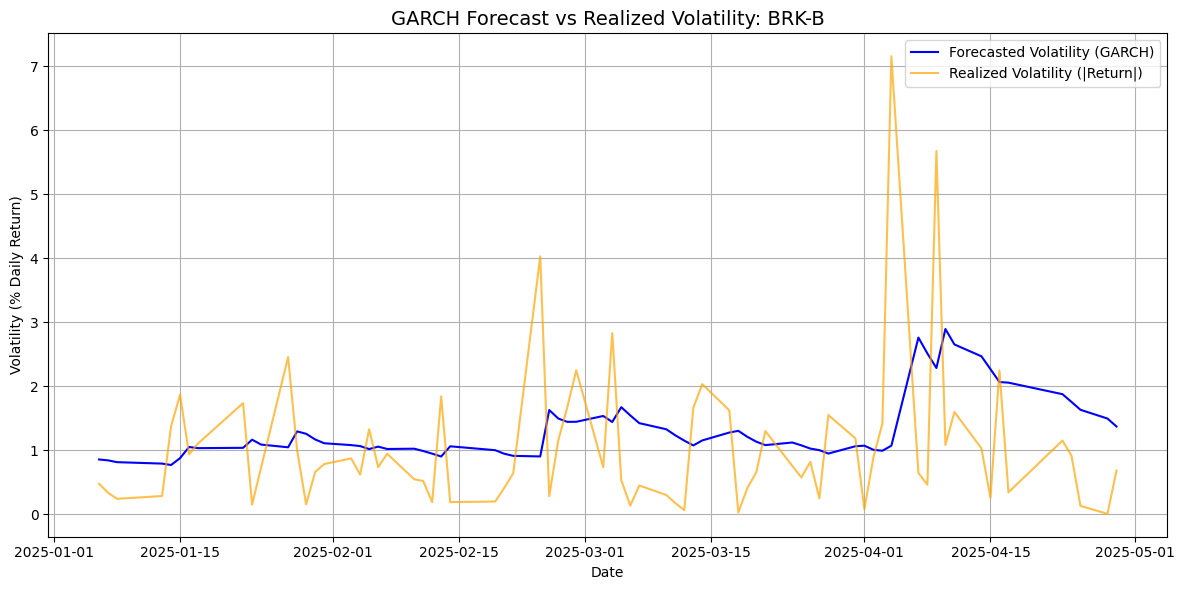

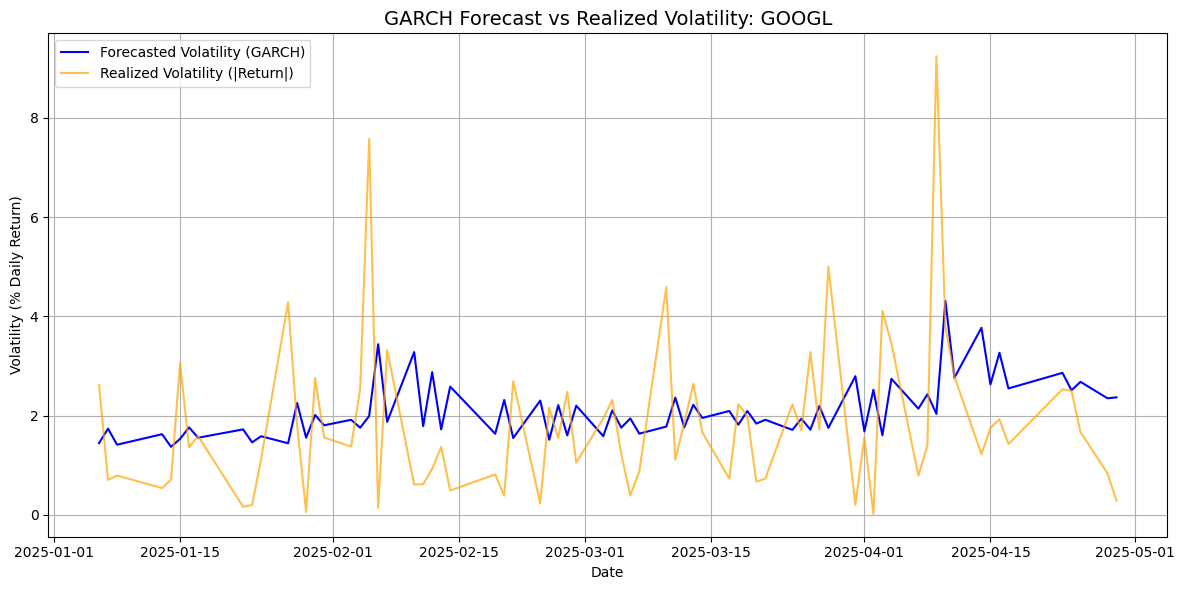

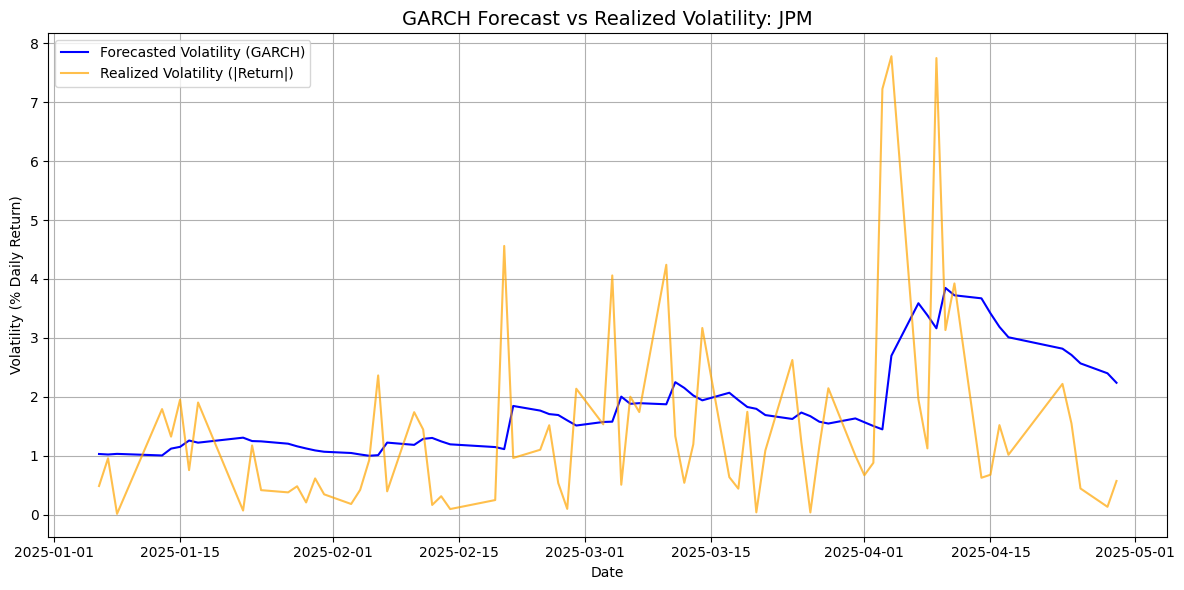

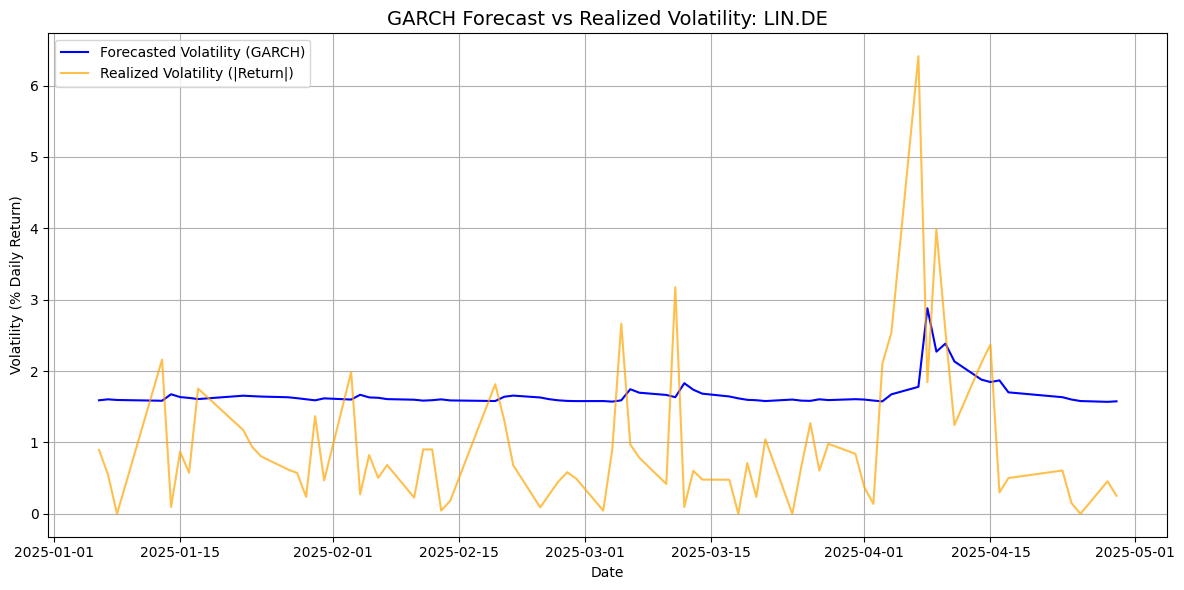

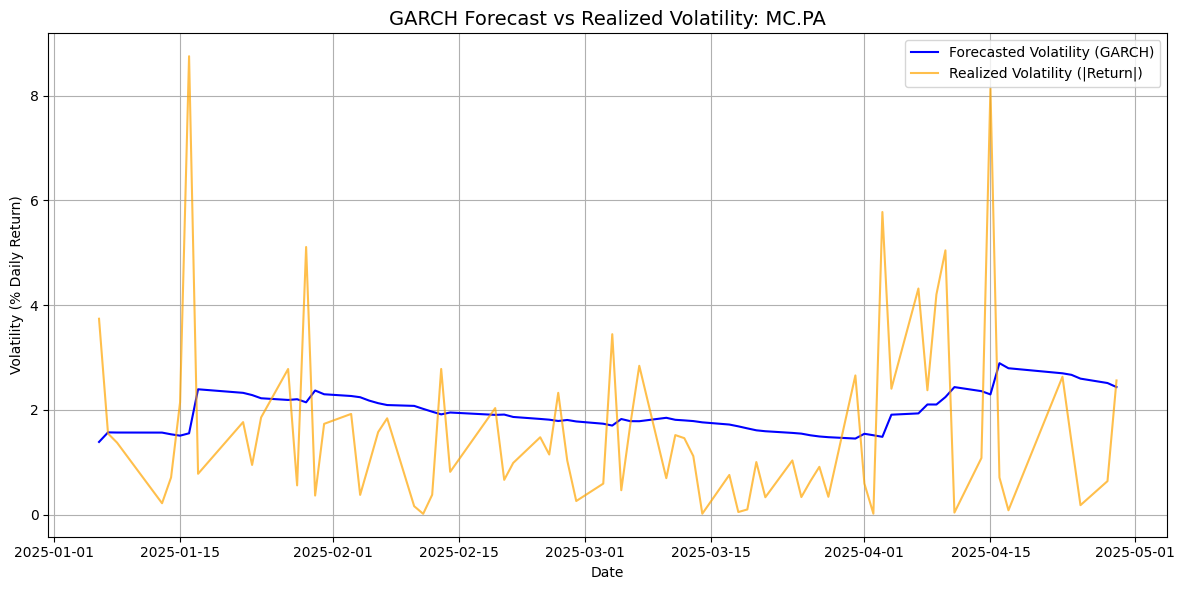

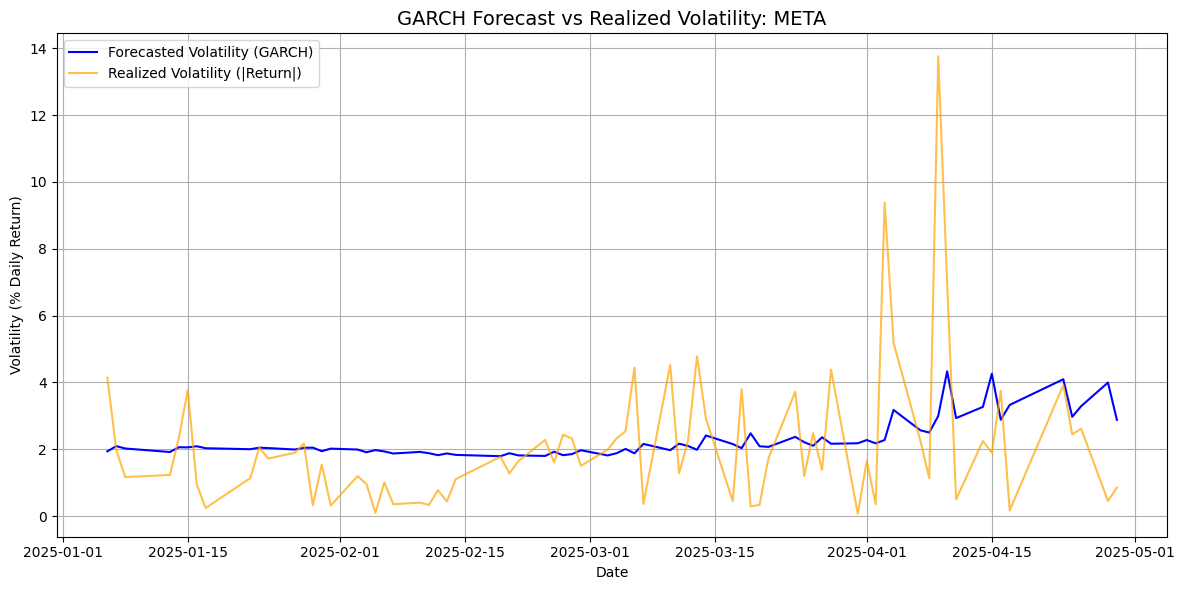

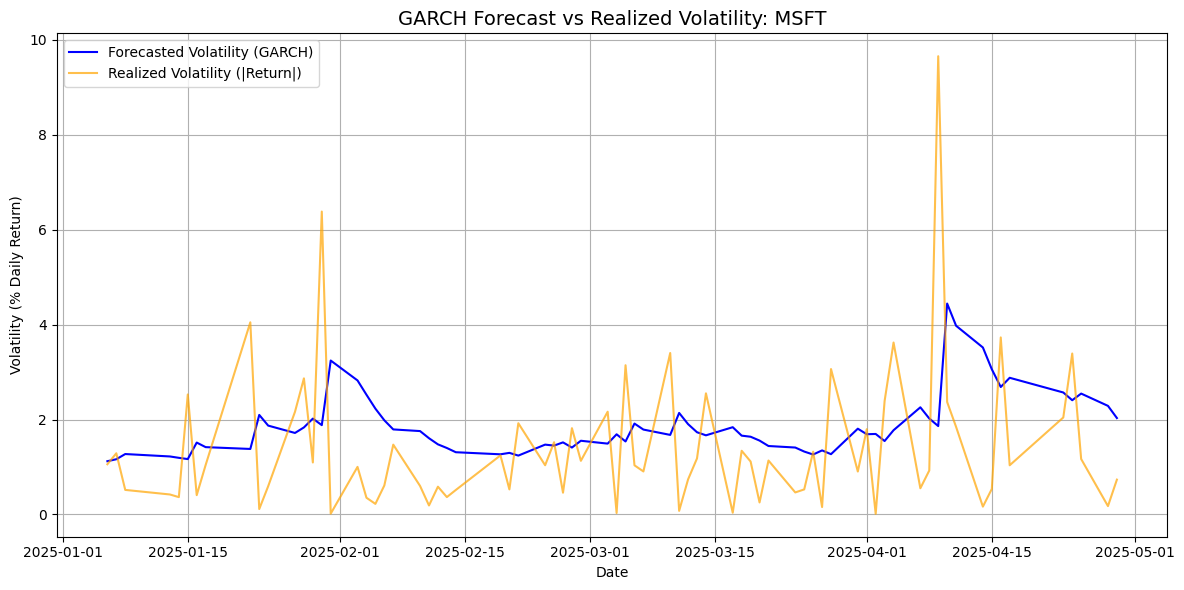

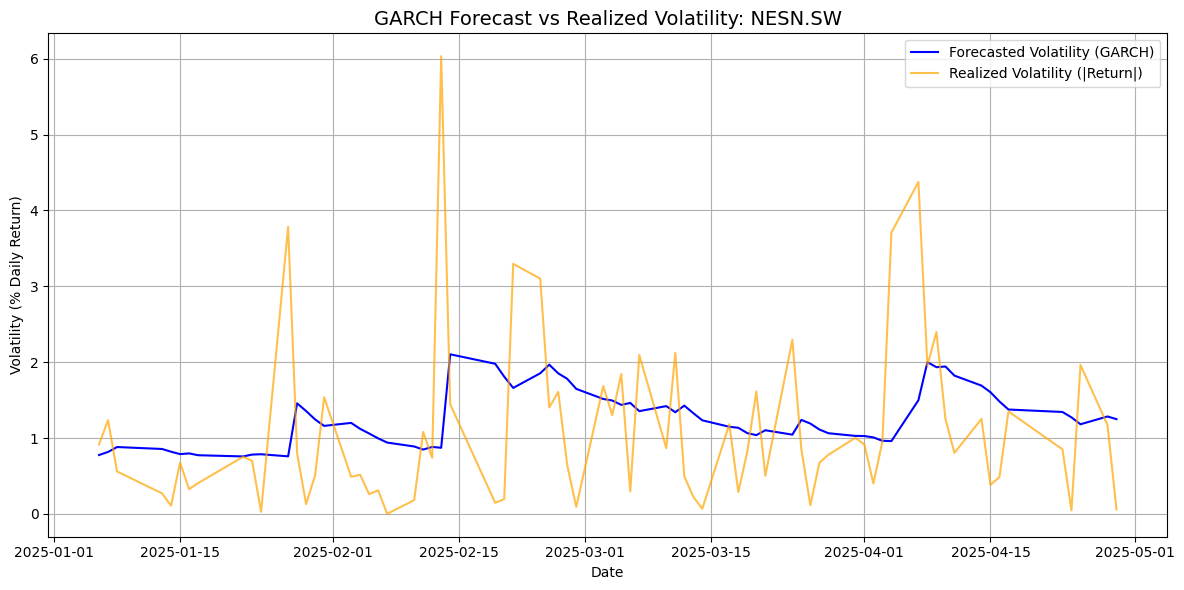

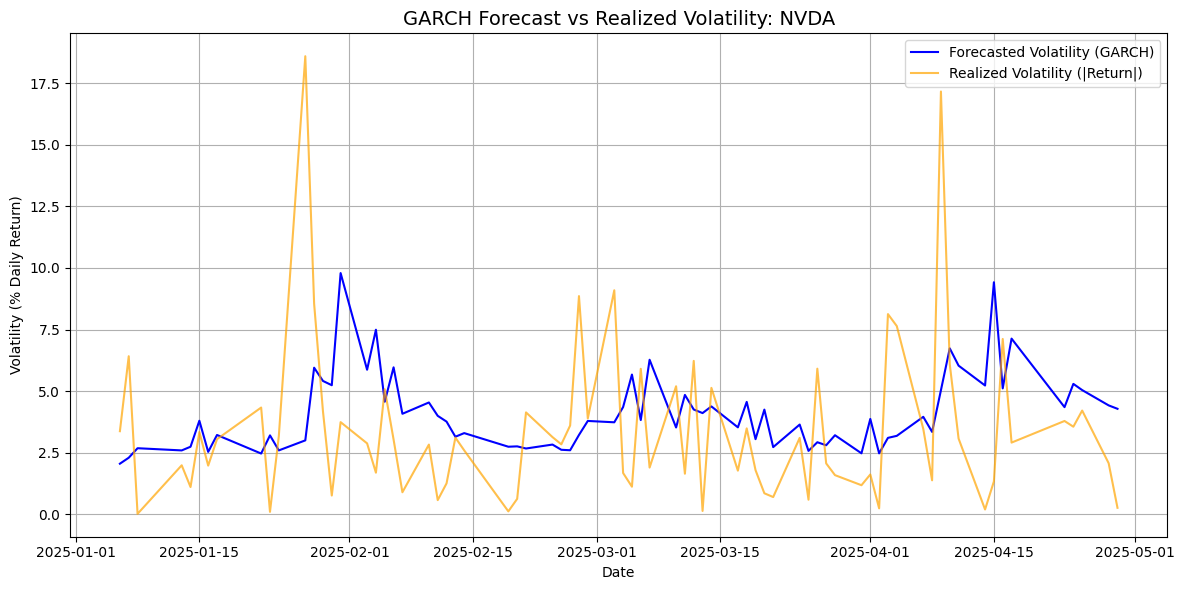

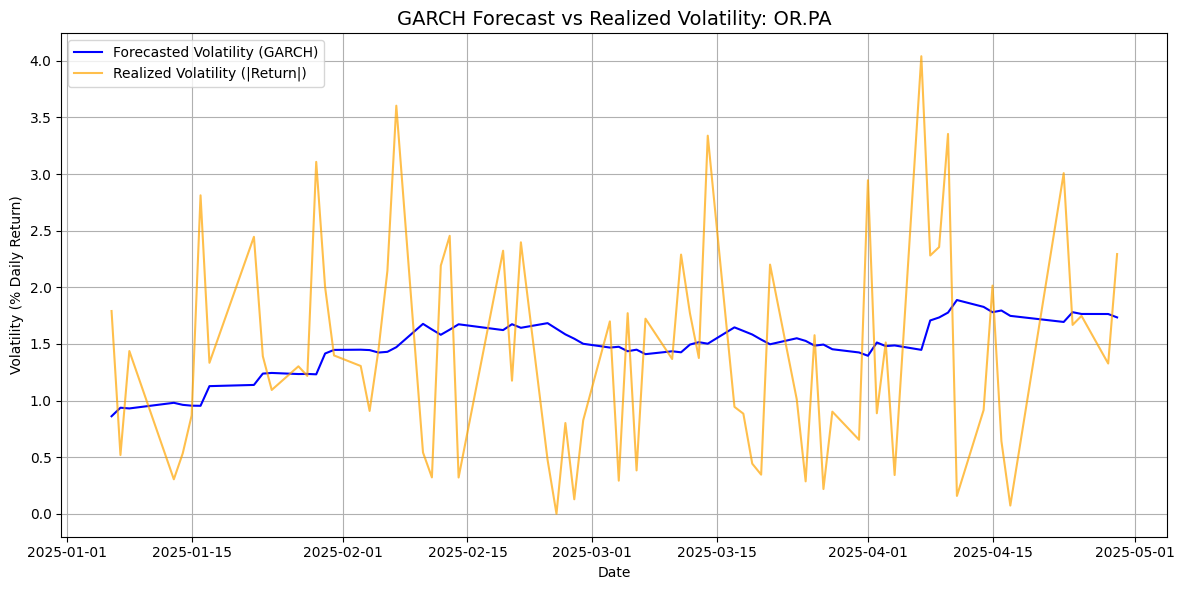

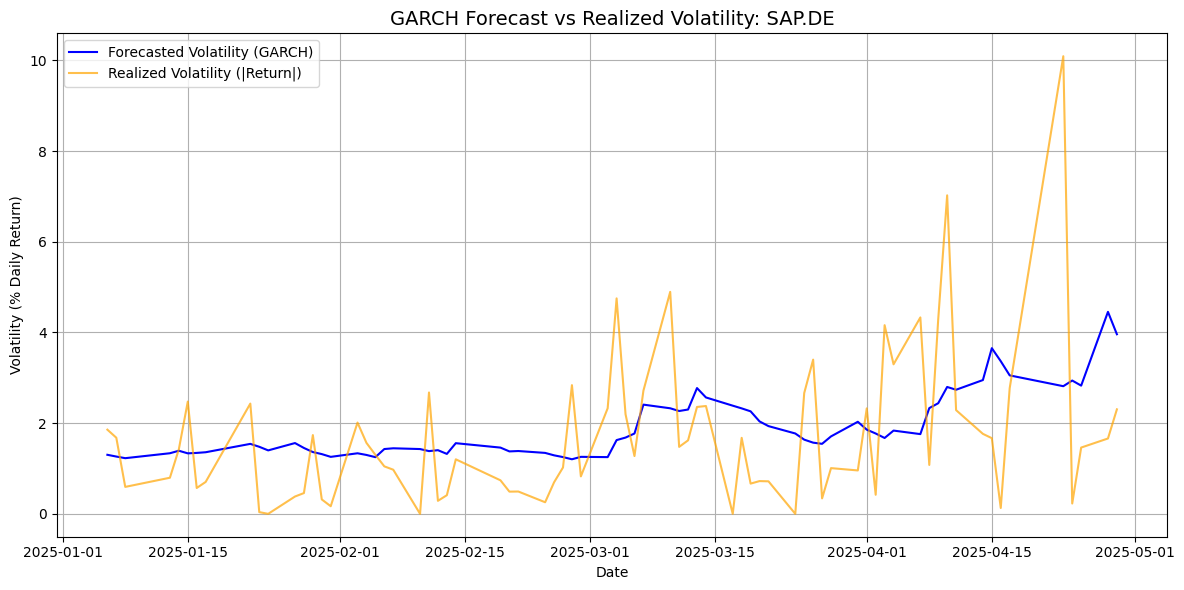

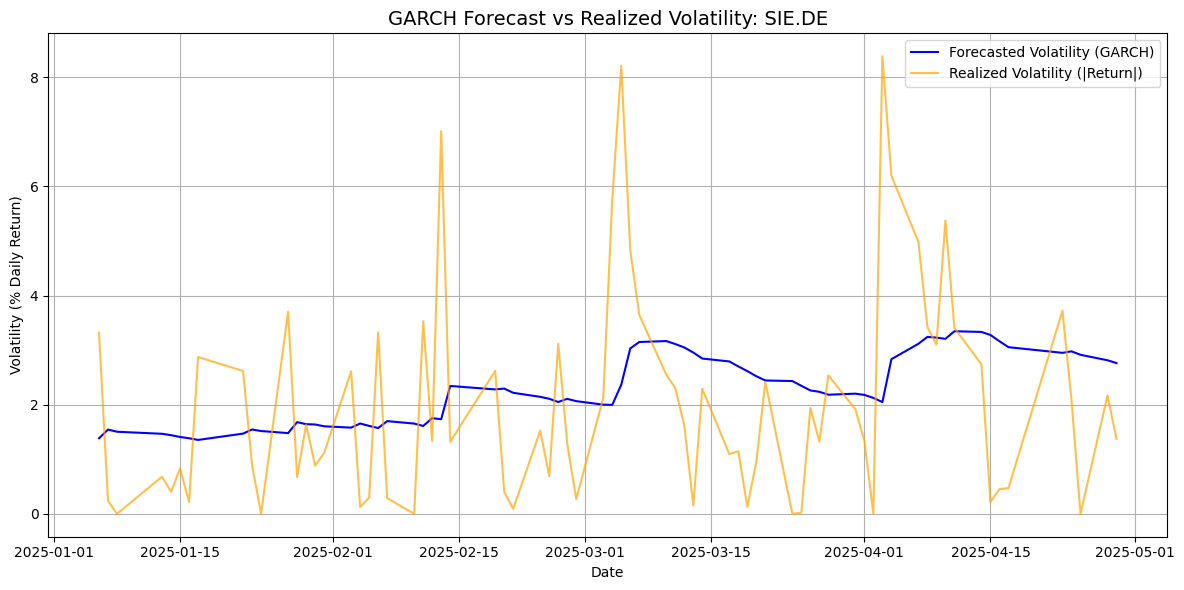

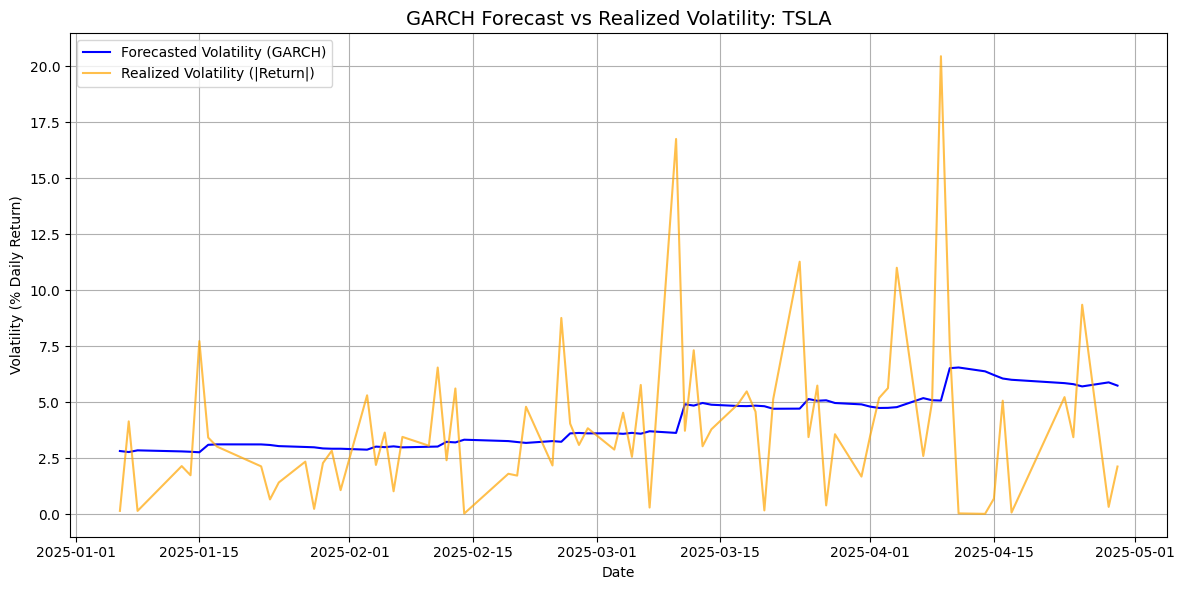

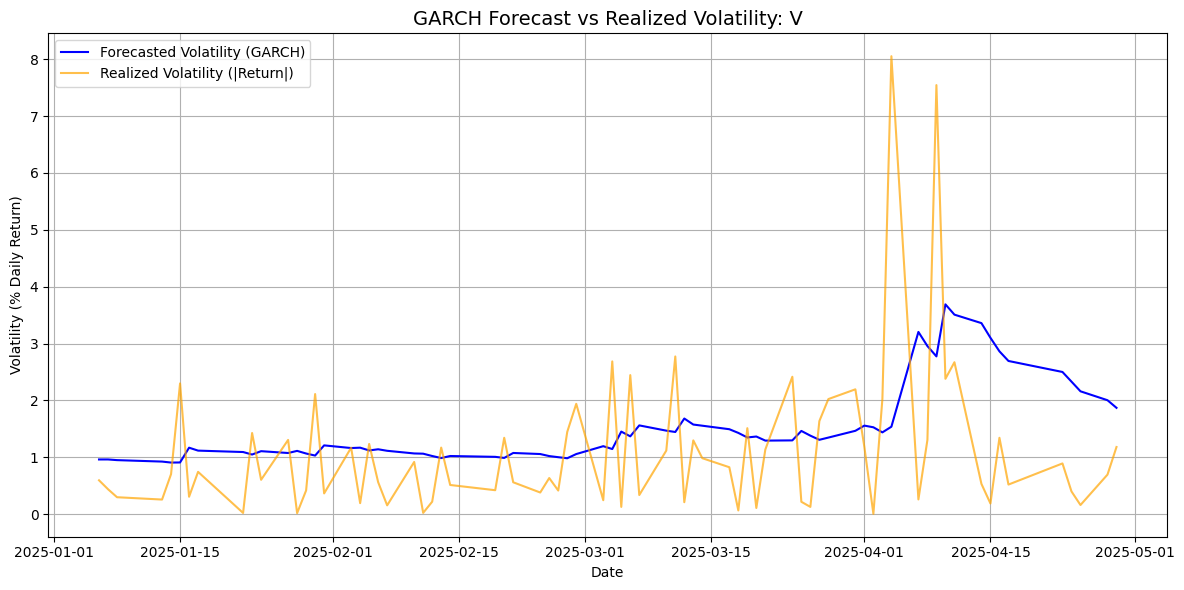

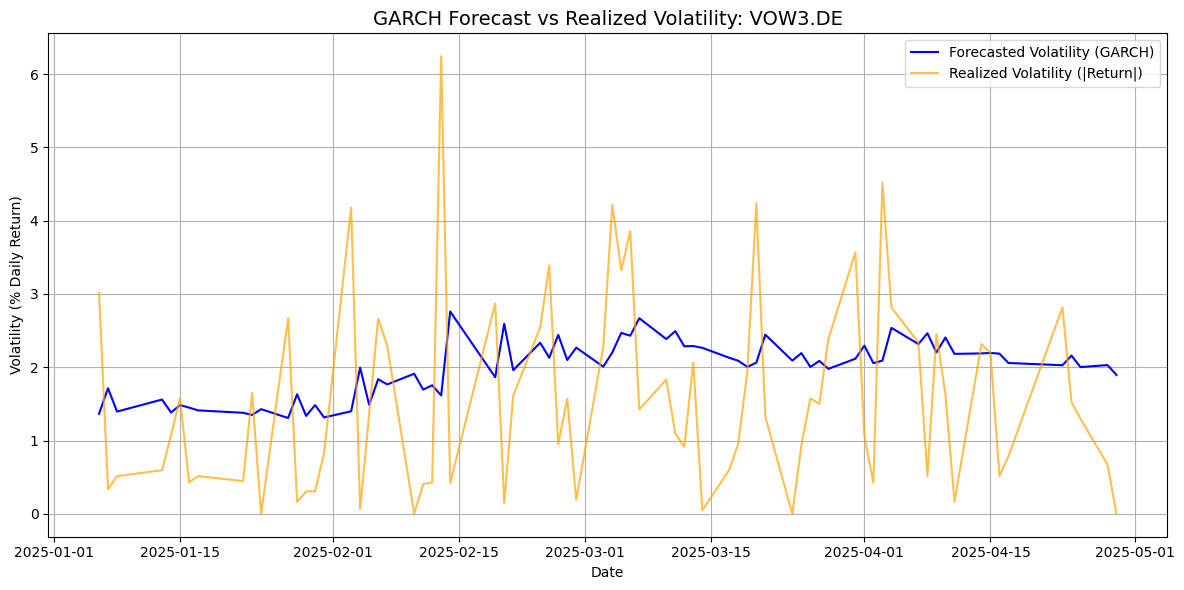

In [14]:
# 7. Plotting
unique_tickers = rolling_df['Ticker'].unique()

for ticker_to_plot in unique_tickers:
    plot_df = rolling_df[rolling_df['Ticker'] == ticker_to_plot].copy()
    plot_df.dropna(subset=['Forecasted_Std', 'Actual'], inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['Date'], plot_df['Forecasted_Std'], label='Forecasted Volatility (GARCH)', color='blue')
    plt.plot(plot_df['Date'], np.abs(plot_df['Actual']), label='Realized Volatility (|Return|)', color='orange', alpha=0.7)

    plt.title(f"GARCH Forecast vs Realized Volatility: {ticker_to_plot}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Volatility (% Daily Return)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
# Filter valid rows
rolling_df_clean = rolling_df.dropna(subset=['Actual', 'Forecasted_Std']).copy()
rolling_df_clean['Realized_Volatility'] = np.abs(rolling_df_clean['Actual'])

# Group by ticker and compute metrics
vol_forecast_metrics = rolling_df_clean.groupby('Ticker').apply(
    lambda df: pd.Series({
        'MAE': mean_absolute_error(df['Realized_Volatility'], df['Forecasted_Std']),
        'RMSE': np.sqrt(mean_squared_error(df['Realized_Volatility'], df['Forecasted_Std']))
    })
).reset_index()

# Show the result
print("\n📊 Forecast Evaluation Metrics (Daily Volatility %):")
print(vol_forecast_metrics)



📊 Forecast Evaluation Metrics (Daily Volatility %):
     Ticker       MAE      RMSE
0      AAPL  1.522514  2.228308
1    AIR.PA  1.153930  1.460713
2    ALV.DE  0.889942  1.170593
3      AMZN  1.351453  1.880892
4   ASML.AS  1.414906  1.832806
5     BRK-B  0.910566  1.269367
6     GOOGL  1.270257  1.742215
7       JPM  1.201607  1.626328
8    LIN.DE  1.060477  1.213820
9     MC.PA  1.344698  1.796585
10     META  1.386151  2.079603
11     MSFT  1.297048  1.714305
12  NESN.SW  0.801679  1.136269
13     NVDA  2.665115  3.676411
14    OR.PA  0.793083  0.984570
15   SAP.DE  1.234072  1.642614
16   SIE.DE  1.504709  1.943803
17     TSLA  2.400147  3.605987
18        V  1.057909  1.459868
19  VOW3.DE  1.168535  1.414243


In [23]:
# 1. Define forecast horizon and future business dates
forecast_horizon = 5
last_obs = log_returns.index[-1]
future_dates = pd.bdate_range(last_obs + BDay(), periods=forecast_horizon)

# 2. Store per‑ticker forecasts
garch_forecasts = {}

# 3. Loop through GARCH summary table and compute forecast for each ticker
for _, row in garch_summary_df.iterrows():
    tkr = row['Ticker']
    p, q = row['Best_BIC_Order']

    r = log_returns[tkr].dropna()
    if r.empty:
        continue

    res = arch_model(r, vol='GARCH', p=p, q=q,
                     mean='Constant', rescale=False).fit(disp='off')

    var_vec = res.forecast(horizon=forecast_horizon).variance.iloc[-1].values
    sigma_vec = np.sqrt(var_vec)  # Convert to standard deviation (σ)

    df = pd.DataFrame({'Sigma (% daily)': sigma_vec}, index=future_dates)
    garch_forecasts[tkr] = df

vol_forecasts_df = pd.concat(garch_forecasts, names=['Ticker', 'Date'])
vol_forecasts_df.index.set_names(['Ticker', 'Date'], inplace=True)

print(wide_format)




Date     2025-04-30  2025-05-01  2025-05-02  2025-05-05  2025-05-06
Ticker                                                             
AAPL       2.997679    2.954931    2.913508    2.873379    2.834513
AIR.PA     2.693119    2.671684    2.650862    2.630637    2.610997
ALV.DE     1.637579    1.629358    1.621410    1.613726    1.606300
AMZN       2.346438    2.339391    2.332841    2.326755    2.321101
ASML.AS    2.146328    1.855224    1.743444    1.821476    1.914333
BRK-B      1.233738    1.225619    1.218032    1.210945    1.204327
GOOGL      2.078981    2.289066    2.106535    2.209569    2.106035
JPM        2.015902    1.994477    1.973959    1.954317    1.935520
LIN.DE     1.521871    1.600878    1.644467    1.668946    1.682821
MC.PA      2.410375    2.390951    2.372015    2.353557    2.335568
META       3.153975    3.303903    3.037528    3.170998    3.253481
MSFT       1.866785    1.853763    1.841838    1.830924    1.820939
NESN.SW    1.160317    1.148151    1.136847    1